# Estimating Gentrification using Street View Images and Embeddings

This script (initially produced by ChatGPT) does the following (_this was my query_):
 - Read a spatial boundary file (that I will hard code)
 - Obtain the road network (from OSM?) for that area
 - Generate sample points on the road network roughly X meters apart
 - At each sample point, download the most recent street images for that location (either a single 360 degree view of a few smaller images). Use whichever API service is the most appropriate for obtaining the images. Importantly please record the date that the image was taken.
 - For each image, calculate an embedding using an appropriate foundation model (one that has been pre-trained to distinguish street environments specifically). Please use Hugging Face libraries.
 - If necessary, calculate the mean embedding for each point (is this the best way to calculate a single embedding for a point represented by multiple images?)
 - Now, for each sampled point there will be a dataframe with information about the point and its embedding. Read another polygon spatial data file, that I will provide, which contains area-level estimates of gentrification.
 - Use point-in-polygon to get the gentrification for each point.
 - Use cross-validation to train a couple of ML models (probaly random forest, linear regression and a neural network) to estimate gentrification from the embedding vectors
 - Choose the best model and parameter configuration and test this model on some held-out data.

## Configuration and library loading

In [2]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import os
from PIL import Image
import numpy as np
import pickle
import torch

# -------------------------------------------------------------
# Function to embed a single image
# -------------------------------------------------------------
def embed_image(img_path):
    if not os.path.exists(img_path):
        return None
    img = Image.open(img_path).convert("RGB")
    inputs = processor(img, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        out = model(**inputs)
    cls = out.last_hidden_state[0, 0, :].cpu().numpy()
    return cls

# -------------------------------------------------------------
# Function to embed all images for a single point
# -------------------------------------------------------------
def embed_point(rec):
    embeds = []
    for img_path in rec["image_files"]:
        img_path = img_path.replace("airbnb-manchester/", "embeddings/").replace("../", "../../")
        cls = embed_image(img_path)
        if cls is not None:
            embeds.append(cls)
    rec["embedding"] = embeds  # keep list of embeddings per point
    return rec

# -------------------------------------------------------------
# Parallelize embedding over points
# -------------------------------------------------------------
already_have_embedding = 0

with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:  # use all CPU cores
    futures = [executor.submit(embed_point, rec) for rec in point_records]
    point_records = [f.result() for f in as_completed(futures)]

print(f"Created {len(point_records)-already_have_embedding} new embeddings. "
      f"{already_have_embedding} points had existing embeddings.")

# -------------------------------------------------------------
# Cache the enriched records
# -------------------------------------------------------------
with open(points_data_cache, "wb") as f:
    pickle.dump(point_records, f)

print(f"✓ {len(point_records)} image embeddings computed and cached.")


NameError: name 'point_records' is not defined

In [ ]:
import os
os.environ["HF_HOME"] = "/nfs/a319/gy17m2a/scratch/gy17m2a/hf_cache"
# os.environ["TRANSFORMERS_CACHE"] = "/nfs/a319/gy17m2a/scratch/gy17m2a/hf_cache"
os.environ["XDG_CACHE_HOME"] = "/nfs/a319/gy17m2a/scratch/gy17m2a/.cache"
os.environ["XDG_CONFIG_HOME"] = "/nfs/a319/gy17m2a/scratch/gy17m2a/.config"
os.environ["TRANSFORMERS_CACHE"] = "/nfs/a319/gy17m2a/scratch/gy17m2a/hf_cache"
os.environ["HF_HOME"] = "/nfs/a319/gy17m2a/scratch/gy17m2a/hf_cache"
os.environ["PIP_CACHE_DIR"] = "/nfs/a319/gy17m2a/scratch/gy17m2a/.cache/pip"
os.environ["MPLCONFIGDIR"] = "/nfs/a319/gy17m2a/scratch/gy17m2a/.config/matplotlib"

from transformers import AutoImageProcessor, AutoModel

import random
import folium
import base64
from pathlib import Path
import requests
import pickle
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString
import numpy as np
import osmnx as ox
import torch
from tqdm.auto import tqdm                    # auto picks notebook / console style
import multiprocessing
import json

from PIL import Image

# For caching models
from joblib import dump, load
from datetime import datetime


# Hugging Face Transformers for image embedding
from transformers import AutoImageProcessor, AutoModel  # will load a vision model

# Matplotlib for visualization
import matplotlib.pyplot as plt


# ----------------- Configuration -----------------
#np.random.seed(42)
density_per_km = 0.3  # number of points to sample per km of road
#density_per_km = 0.1  # VERY FEW WHILE TESTING
DOWNLOAD_IMAGES = False  # If false then don't download any images, just load those that have been cached

# Can decide, after analysing images, which models we want to run (to predict gentrification and/or deprivation)
RUN_GENTRIFICATION_MODEL = False  
RUN_IMD_MODEL = False  # (This one is actually more about running a grid search to find the optimal model 
                      # for the deprivation analysis. WHen False then it still runs models, but doesn't conduct the laborious search) 

data_dir = Path(os.path.join("..", "data", "airbnb-manchester"))
boundary_file = os.path.join(data_dir, "greater_manchester_lsoas.geojson")  # Path to boundary polygon file
gentrification_file = os.path.join("..", "data", "gmgi_data", "lsoa_summary_jan25.csv")  # Path to polygons with gentrification index
lsoas_file = os.path.join("..", "data/SpatialData/", "LSOAs_2011", "LSOA_2011_EW_BSC_V4.shp")
imd_file = os.path.join("..", "data", "imd", "File_2_-_IoD2019_Domains_of_Deprivation.xlsx")
sample_spacing = 200.0   # distance in meters between sample points on roads
#sample_spacing = 5000.0  # Very large for testing
n_directions = 4         # number of street view images per point (e.g., 4 cardinal directions)
image_size = "640x640"   # requested image resolution from Street View API

# Create directories for caching if not exist
#Path(data_dir).mkdir(parents=True, exist_ok=True)
image_dir = Path(os.path.join(data_dir, "street_images"))
image_dir.mkdir(exist_ok=True)

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Loading

In [45]:
# --- Load neighbourhood polygons and dissolve to one study-area boundary ---
boundary_neighs = gpd.read_file(boundary_file)
# (Optional) keep original neighbourhoods for later mapping/stratified sampling
#neighbourhoods_gdf = boundary_neighs.copy()
# Make sure we're in WGS84 (lat/lon) for OSM and APIs
boundary_neighs = boundary_neighs.to_crs(epsg=4326)
# Dissolve: merge all geometries into one polygon (MultiPolygon possible)
boundary_polygon = boundary_neighs.unary_union  # shapely (multi)polygon
boundary_gdf = gpd.GeoDataFrame(
    data={'name': ['study_area']},
    geometry=[boundary_polygon],
    crs=boundary_neighs.crs)

# TEMP! Just keep one LSOA for testing
#boundary_gdf = boundary_neighs.sample(1)

print("Merged neighbourhoods into single study-area boundary.")
print("Bounds:", boundary_polygon.bounds)
# boundary_gdf.plot(color='lightblue', edgecolor='black')

Merged neighbourhoods into single study-area boundary.
Bounds: (-2.73052481406758, 53.3281053809015, -1.90962093258169, 53.6857339236763)


/tmp/ipykernel_17617/3415185878.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boundary_polygon = boundary_neighs.unary_union  # shapely (multi)polygon


## Read the LSOA boundary data

(later it will be joined to the Greater Manchester Gentrification Index and IMD)

In [46]:
lsoas =  gpd.read_file(lsoas_file)
manc_lads = ['Manchester', 'Rochdale', 'Bolton', 'Bury', 'Wigan', 'Oldham',  'Trafford', 'Salford', 'Tameside', 'Stockport']
manc_lads_pattern = '|'.join(manc_lads)
gm_lsoa=lsoas[lsoas['LSOA11NMW'].str.contains(manc_lads_pattern)]
gm_lsoa = gm_lsoa.to_crs(epsg=4326)
# gm_lsoa.plot()

## Get Road Network for the Area from OSM

In [4]:
# Get (or cache) the road network with OSMnx’s built-in GraphML I/O
# --------------------------------------------------------------------

# Tell OSMnx to keep all cache files inside the project folder (optional)
#ox.settings.cache_folder = str(data_dir / "osmnx_http_cache")  # HTTP/tile cache
#ox.settings.use_cache = True  # default is True
ox.settings.use_cache = False      # <- prevents the “cache” dir being written


graph_file = data_dir / "road_network.graphml"  # one self-contained file

if graph_file.exists():
    print("Loading road network from GraphML cache …")
    road_graph = ox.load_graphml(graph_file)
else:
    print("Downloading road network from OSM …")
    road_graph = ox.graph_from_polygon(boundary_polygon, network_type="drive")
    ox.save_graphml(road_graph, graph_file)
    print(f"Graph saved to {graph_file}")

# Convert to GeoDataFrame of edges for downstream sampling/plotting
edges_gdf = ox.graph_to_gdfs(road_graph, nodes=False)

print(f"Number of road segments: {len(edges_gdf)}")


Loading road network from GraphML cache …
Number of road segments: 232675


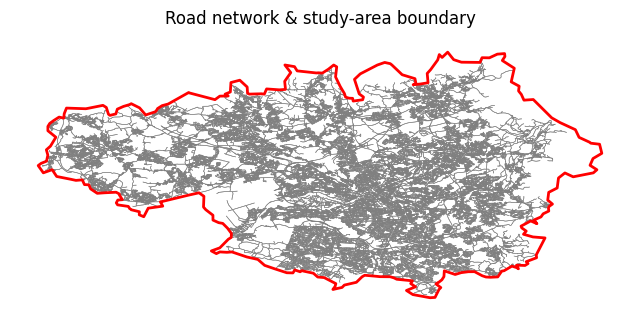

In [5]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot roads first (thin gray lines)
edges_gdf.plot(ax=ax, linewidth=0.4, color="gray")

# Plot the study-area outline on top (thicker red line)
boundary_gdf.boundary.plot(ax=ax, linewidth=2, edgecolor="red")

ax.set_title("Road network & study-area boundary", pad=12)
ax.set_axis_off()          # hides lat/lon ticks for a cleaner look
ax.set_aspect("equal")     # keeps the map from looking stretched

plt.show()

In [95]:
# Cache file for the entire points data with embeddings (images are stored separately)
DEBUG = False
points_data_cache = data_dir / "points_with_embeddings.pkl"

# -----------------------------------------------------------
# Load existing cache so we can *append* new sample points
# -----------------------------------------------------------
if points_data_cache.exists():
    print("Loading cached point data …")
    with open(points_data_cache, "rb") as f:
        point_records = pickle.load(f)
    existing_coords = {(rec["latitude"], rec["longitude"]) for rec in point_records}
    next_id = max(rec["point_id"] for rec in point_records) + 1
else:
    point_records = []
    existing_coords = set()
    next_id = 0

print(f"Cache currently has {len(point_records)} points.")
added_this_run = 0

Loading cached point data …
Cache currently has 18897 points.


Map of the full sample (cache + any others just downlaoded)

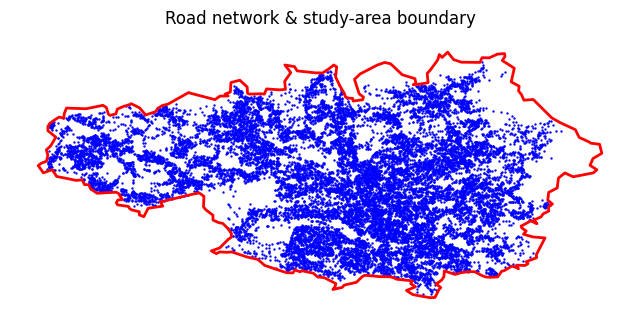

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot roads first (thin gray lines)
#edges_gdf.plot(ax=ax, linewidth=0.4, color="gray")

# Plot the sample points
gpd.GeoDataFrame(point_records, 
                 geometry=[Point(rec["longitude"], rec["latitude"]) for rec in point_records], 
                 crs="EPSG:4326").plot(ax=ax, color="blue", markersize=0.5, label="Sample Points")

# Plot the study-area outline on top (thicker red line)
boundary_gdf.boundary.plot(ax=ax, linewidth=2, edgecolor="red")

ax.set_title("Road network & study-area boundary", pad=12)
ax.set_axis_off()          # hides lat/lon ticks for a cleaner look
ax.set_aspect("equal")     # keeps the map from looking stretched

plt.show()

Show some randomly chosen images

## Compute the Embeddings

(Note: would like to use Places365 but not available in Hugging Face yet, so using ViT base model instead)

In [ ]:
# -------------------------------------------------------------
# Load ViT-Base (ImageNet-21k) and pick CUDA ▸ MPS ▸ CPU device
# -------------------------------------------------------------

model_name = "google/vit-base-patch16-224-in21k"
print(f"Loading {model_name} …")
processor   = AutoImageProcessor.from_pretrained(model_name)
model       = AutoModel.from_pretrained(model_name).eval()   # no classifier head

# ----- smart device selection -----
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("✔ Using CUDA GPU")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")      # Apple-Silicon Metal
    print("✔ Using Apple MPS GPU")
else:
    device = torch.device("cpu")
    print("✔ Using CPU")

model.to(device)

# -------------------------------------------------------------
# Embed all images for each point
# -------------------------------------------------------------
already_have_embedding = 0
for rec in point_records:
    embeds = []
    # Skip records that already have an embedding
    # if rec.get("embedding") is not None:
    #     already_have_embedding += 1
    #     continue
    embeds = []
    for img_path in rec["image_files"]:
        if not os.path.exists(img_path):
            continue
        # Load & convert to RGB (some JPEGs are encoded as P)
        img = Image.open(img_path).convert("RGB")

        # Tokenize and normalize the image
        inputs = processor(img, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}   # move tensors

        # Forward pass through the model (no gradients needed)
        with torch.no_grad():
            out = model(**inputs)

        # Extract the CLS token embedding (first token in the sequence)
        cls = out.last_hidden_state[0, 0, :].cpu().numpy()     # CLS token
        embeds.append(cls)

    # Store the mean embedding for this point (or none)
    rec["embedding"] = embeds # None if not embeds else np.mean(embeds, axis=0)

print(f"Created {len(point_records)-already_have_embedding} new embeddings. "
      f"{already_have_embedding} points had existing embeddings.")

# cache the enriched records
with open(points_data_cache, "wb") as f:
    pickle.dump(point_records, f)

print(f"✓ {len(point_records)} image embeddings computed and cached.")


Loading google/vit-base-patch16-224-in21k …
✔ Using CPU


Do a PCA to get 3 dimensions for each embedding, the scale to RGB and map them. Click on a point to see the images.

Join image embeddings points to gentrification LSOAs (so we have the 'ground truth' gentrification score).

In [18]:
# Check all records have an embeding
invalid_records = [rec for rec in point_records if rec.get('embedding') is None]
assert len(invalid_records)==0, f"Found {len(invalid_records)} invalid points"

# Now join the embeddings points to the LSOAs
point_coords = [Point(rec['longitude'], rec['latitude']) for rec in point_records]
points_labels_gdf = gpd.GeoDataFrame(point_records, geometry=point_coords, crs="EPSG:4326")

# Perform spatial join to get gentrification label for each point
points_labels_gdf = gpd.sjoin(points_labels_gdf, gm_gmgi_lsoa, how='inner', predicate='within')
# sjoin may add an index from the polygon ('index_right'); we can drop it
if 'index_right' in points_labels_gdf.columns:
    points_labels_gdf = points_labels_gdf.drop(columns=['index_right'])

print(f"Points after spatial join: {len(points_labels_gdf)} / {len(point_records)}"
      f" `(some points may lie outside the label polygons and were dropped)")

Points after spatial join: 18897 / 18897 `(some points may lie outside the label polygons and were dropped)


Show them on a map

<Axes: >

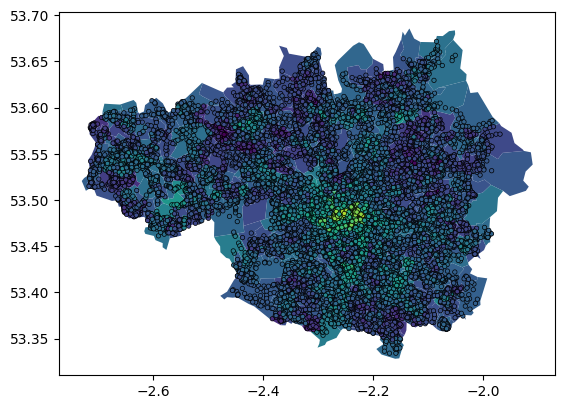

In [19]:
label_col = 'gi_n'
ax = gm_gmgi_lsoa.plot(column=label_col)
# Add the points
points_labels_gdf.plot(ax=ax, column=label_col, markersize=10, edgecolor="black", linewidth=0.5)

Prepare X and y data for the ML model

In [20]:
# ------------------------------------------------------------------
# Validate point records before building X, y
# ------------------------------------------------------------------
def _is_bad_embedding(e):
    """True if embedding is missing, not a numpy array, or empty."""
    return (e is None) or (not isinstance(e, np.ndarray)) or (e.size == 0)


# Boolean masks
missing_label  = points_labels_gdf[label_col].isna()
bad_embedding  = points_labels_gdf["embedding"].apply(_is_bad_embedding)

# Report any problems
n_bad_label   = missing_label.sum()
n_bad_embed   = bad_embedding.sum()
n_bad_total   = (missing_label | bad_embedding).sum()

if n_bad_total:
    msg = (f"⚠️  {n_bad_total} invalid point(s) detected "
           f"({n_bad_label} with missing label, "
           f"{n_bad_embed} with missing/empty embedding).")
    print(msg)

    # show first few offending rows for inspection
    print(points_labels_gdf.loc[missing_label | bad_embedding,
                                ["point_id", label_col, "embedding"]].head())

else:
    print(f"{n_bad_total} invalid point(s) detected ")

# ------------------------------------------------------------------
# Keep only valid rows
# ------------------------------------------------------------------
points_labels_gdf = points_labels_gdf.loc[~(missing_label | bad_embedding)].reset_index(drop=True)

if points_labels_gdf.empty:
    raise ValueError("No valid points left after cleaning — cannot train model.")

# ------------------------------------------------------------------
# Build feature matrix X and target vector y
# ------------------------------------------------------------------
X = np.stack(points_labels_gdf["embedding"].values)     # shape (n_points, embed_dim)
y = points_labels_gdf[label_col].values

print("Feature matrix shape:", X.shape, "Target vector shape:", y.shape)


0 invalid point(s) detected 
Feature matrix shape: (18897, 768) Target vector shape: (18897,)


### Aggregating the image imbeddings

Currently we have large numbers of images (and embeddings) per LSOA. But each LSOA only has a single deprivation value

[ ] TODO Try aggregating the image embeddings to LSOA and then predicting the model

The average embedding in a LSOA should represent the average streetscape characterstic in the neighbourhood. This could be problematic if the mean embedding blurs distinct subtypes - e.g. if half of the neighbourhood is suburban and the other half are industrial, the mean might sit somewhere useless in the meaning.


In [ ]:
# Stack embeddings into a 2D array
emb_matrix = np.vstack(one_lsoa['embedding'].values)

# Compute the elementwise mean
mean_embedding = emb_matrix.mean(axis=0)

In [39]:
def mean_embed(x):
    return np.mean(np.vstack(x), axis=0)

avg_embeddings = (
    points_labels_gdf.groupby("LSOA11CD")["embedding"]
      .apply(mean_embed)
      .reset_index())

In [55]:
import numpy as np
from sklearn.cluster import KMeans

In [93]:
one_lsoa['image_files'][2819]

['../data/airbnb-manchester/street_images/point2861_heading0.jpg',
 '../data/airbnb-manchester/street_images/point2861_heading90.jpg',
 '../data/airbnb-manchester/street_images/point2861_heading180.jpg',
 '../data/airbnb-manchester/street_images/point2861_heading270.jpg']

In [86]:
one_lsoa = points_labels_gdf[points_labels_gdf['LSOA11CD'] == 'E01005097']
print(len(one_lsoa))

# helper: stack and normalize embeddings
embs = np.vstack(one_lsoa['embedding'].values)   # shape (n_samples, dim)
# normalize to unit length (recommended for cosine)
norms = np.linalg.norm(embs, axis=1, keepdims=True)
norms[norms==0] = 1.0
embs_norm = embs / norms

# 1) Simple mean (baseline)
mean_emb = embs_norm.mean(axis=0)
mean_emb = mean_emb / np.linalg.norm(mean_emb)   # renormalize

# 2) Robust median
median_emb = np.median(embs_norm, axis=0)
median_norm = np.linalg.norm(median_emb)
if median_norm > 0:
    median_emb /= median_norm

# 3) Clustering approach (KMeans example)
k = 3   # tune per LSOA or find with elbow
kmeans = KMeans(n_clusters=k, random_state=0).fit(embs_norm)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_   # already in normalized space? KMeans centroids may not be unit norm
centroids = (centroids.T / np.linalg.norm(centroids, axis=1)).T  # renormalize centroids

# cluster sizes (proportions)
unique, counts = np.unique(labels, return_counts=True)
proportions = counts / counts.sum()

# weighted centroid (one-vector summary)
weighted_centroid = (proportions[:,None] * centroids).sum(axis=0)
weighted_centroid /= np.linalg.norm(weighted_centroid)

# 4) Alternative: HDBSCAN (if multimodal with unknown k)
# import hdbscan
# clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
# labels = clusterer.fit_predict(embs_norm)
# filter out noise labels (-1) when computing proportions/centroids

# 5) Returnable LSOA-level outputs:
#  - single-vector summaries: mean_emb, median_emb, weighted_centroid
#  - richer summary: list of (centroid, proportion) for each cluster
cluster_summary = [(int(l), centroids[i], float(proportions[i])) for i,l,i in zip(unique, unique, range(len(unique)))]

10


In [67]:
# for each cluster, get top-5 nearest images to centroid
from sklearn.metrics.pairwise import cosine_similarity

sim = cosine_similarity(centroids, embs_norm)  # (k, n)
top_idxs_per_cluster = [np.argsort(sim[i])[::-1][:5] for i in range(k)]
# map these idxs back to your one_lsoa rows to inspect images/locations
one_lsoa has a column ['image_files'] which contains a list of four images e.g. '../data/airbnb-manchester/street_images/point0_heading0.jpg'

['../data/airbnb-manchester/street_images/point0_heading0.jpg',
 '../data/airbnb-manchester/street_images/point0_heading90.jpg',
 '../data/airbnb-manchester/street_images/point0_heading180.jpg',
 '../data/airbnb-manchester/street_images/point0_heading270.jpg']

In [74]:
# shape (n, d)
embs_norm = np.vstack(one_lsoa['embedding'].values)
# cluster centroids (k, d)
centroids = kmeans.cluster_centers_
# cosine similarities (k, n)
sim = cosine_similarity(centroids, embs_norm)

# get top 5 indices for each cluster
top_idxs_per_cluster = [np.argsort(sim[i])[::-1][:5] for i in range(k)]


In [75]:
# For each cluster, extract top-5 image file paths
top_images_per_cluster = []
for i, idxs in enumerate(top_idxs_per_cluster):
    cluster_images = one_lsoa.iloc[idxs]['image_files'].values
    top_images_per_cluster.append(cluster_images)


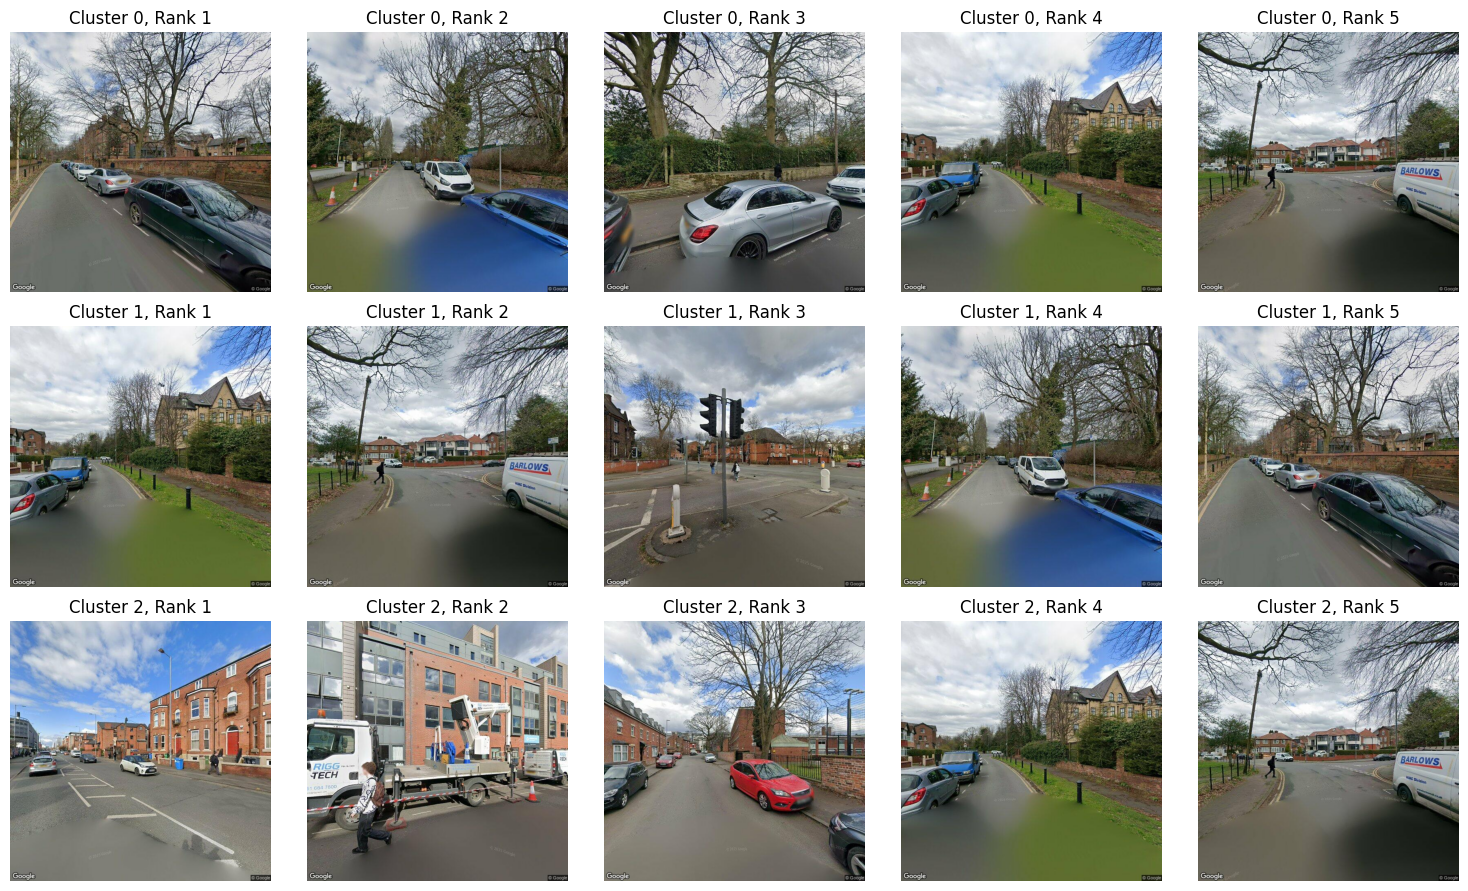

In [76]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# --- compute similarities (assuming you already have centroids and embs_norm) ---
sim = cosine_similarity(centroids, embs_norm)  # shape (k, n)
top_idxs_per_cluster = [np.argsort(sim[i])[::-1][:5] for i in range(k)]

# --- function to plot images ---
def plot_top_images_per_cluster(df, top_idxs_per_cluster, img_col='image_files', k=None):
    if k is None:
        k = len(top_idxs_per_cluster)
    n_top = len(top_idxs_per_cluster[0])

    fig, axes = plt.subplots(k, n_top, figsize=(3 * n_top, 3 * k))
    if k == 1:
        axes = np.expand_dims(axes, 0)  # ensure consistent shape

    for i in range(k):
        for j, idx in enumerate(top_idxs_per_cluster[i]):
            # handle cases where image_files contains a list of multiple headings
            img_entry = df.iloc[idx][img_col]
            if isinstance(img_entry, list):
                img_path = img_entry[0]  # choose first heading or adapt as needed
            else:
                img_path = img_entry

            try:
                img = mpimg.imread(img_path)
                axes[i, j].imshow(img)
                axes[i, j].set_title(f"Cluster {i}, Rank {j+1}")
                axes[i, j].axis('off')
            except Exception as e:
                axes[i, j].text(0.5, 0.5, f"Error\n{e}", ha='center', va='center')
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# --- call it ---
plot_top_images_per_cluster(one_lsoa, top_idxs_per_cluster, img_col='image_files')
